In [348]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report
from statsmodels.graphics.gofplots import qqplot

## 讀入.csv檔 和 資料預處理

In [349]:
dataset = pd.read_csv('../Dataset/SeoulBikeData.csv', encoding='utf-8') ## 讀.csv檔
dataset.head()
# print(dataset.shape)

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [350]:
dataset.dtypes

Date                         object
Rented Bike Count             int64
Hour                          int64
Temperature(C)              float64
Humidity(%)                   int64
Wind speed (m/s)            float64
Visibility (10m)              int64
Dew point temperature(C)    float64
Solar Radiation (MJ/m2)     float64
Rainfall(mm)                float64
Snowfall (cm)               float64
Seasons                      object
Holiday                      object
Functioning Day              object
dtype: object

In [351]:
dataset.shape

(8760, 14)

In [352]:
dataset_date = dataset.iloc[:, 0] ## 變更dataframe的Date改為Month
dataset_month = []
for s in dataset_date:
    date_str = s.split('/')
    dataset_month.append(int(date_str[1]))
    
del dataset['Date']
dataset.insert(0, 'Month', dataset_month)

dataset_rented_bike_count = dataset.iloc[:, 1] ## 變更dataframe的Rented Bike Count(將所有0改1)
for i in range(len(dataset_rented_bike_count)):
    if dataset.iloc[i, 1] == 0:
        dataset.iloc[i, 1] = 1

dataset_seasons = dataset.iloc[:, 11] ## 變更dataframe的Seasons
for i in range(len(dataset_seasons)):
    if dataset.iloc[i, 11] == 'Winter':
        dataset.iloc[i, 11] = 0
    elif dataset.iloc[i, 11] == 'Spring':
        dataset.iloc[i, 11] = 1
    elif dataset.iloc[i, 11] == 'Summer':
        dataset.iloc[i, 11] = 2
    elif dataset.iloc[i, 11] == 'Autumn':
        dataset.iloc[i, 11] = 3
    else:
        print('Data Error(Seasons) row = ', i)

dataset_holiday = dataset.iloc[:, 12] ## 變更dataframe的Holiday
for i in range(len(dataset_holiday)):
    if dataset.iloc[i, 12] == 'No Holiday':
        dataset.iloc[i, 12] = 0
    elif dataset.iloc[i, 12] == 'Holiday':
        dataset.iloc[i, 12] = 1
    else:
        print('Data Error(Holiday) row = ', i)

dataset_functioning_day = dataset.iloc[:, 13] ## 變更dataframe的Functioning Day
for i in range(len(dataset_functioning_day)):
    if dataset.iloc[i, 13] == 'No':
        dataset.iloc[i, 13] = 0
    elif dataset.iloc[i, 13] == 'Yes':
        dataset.iloc[i, 13] = 1
    else:
        print('Data Error(Functioning Day) row = ', i)
dataset.rename(columns={'Rented Bike Count':'RentedBikeCount',
                        'Temperature(C)':'Temperature',
                        'Humidity(%)':'Humidity',
                        'Wind speed (m/s)':'WindSpeed',
                        'Visibility (10m)':'Visibility',
                        'Dew point temperature(C)':'DewPointTemperature',
                        'Solar Radiation (MJ/m2)':'SolarRadiation',
                        'Rainfall(mm)':'Rainfall',
                        'Snowfall (cm)':'Snowfall',
                        'Functioning Day':'FunctioningDay'}, inplace=True)

dataset.head()

,Month,RentedBikeCount,Hour,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,SolarRadiation,Rainfall,Snowfall,Seasons,Holiday,FunctioningDay
0,12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1
1,12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1
2,12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1
3,12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1
4,12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1


In [353]:
dataset.dtypes

Month                    int64
RentedBikeCount          int64
Hour                     int64
Temperature            float64
Humidity                 int64
WindSpeed              float64
Visibility               int64
DewPointTemperature    float64
SolarRadiation         float64
Rainfall               float64
Snowfall               float64
Seasons                 object
Holiday                 object
FunctioningDay          object
dtype: object

## 確認資料量並沒有因此被改動

In [354]:
dataset.shape

(8760, 14)

## 將不需要比較大小的值屬性改為category，達到沒有大小順序之分

In [355]:
dataset['Month'] = dataset.Month.astype('category')
dataset['Hour'] = dataset.Hour.astype('category')
dataset['Seasons'] = dataset.Seasons.astype('category')
dataset['Holiday'] = dataset.Holiday.astype('category')
dataset['FunctioningDay'] = dataset.FunctioningDay.astype('category')
dataset.dtypes

Month                  category
RentedBikeCount           int64
Hour                   category
Temperature             float64
Humidity                  int64
WindSpeed               float64
Visibility                int64
DewPointTemperature     float64
SolarRadiation          float64
Rainfall                float64
Snowfall                float64
Seasons                category
Holiday                category
FunctioningDay         category
dtype: object

In [356]:
dataset.shape

(8760, 14)

In [357]:
dataset.isnull().any()
# dataset = dataset.dropna() ## 若有missing data 就用此去除整行

Month                  False
RentedBikeCount        False
Hour                   False
Temperature            False
Humidity               False
WindSpeed              False
Visibility             False
DewPointTemperature    False
SolarRadiation         False
Rainfall               False
Snowfall               False
Seasons                False
Holiday                False
FunctioningDay         False
dtype: bool

## 視覺化欄位關係圖，以便觀察分析自行車在各個時間點的使用量

[Text(0.5, 1.0, 'Every Months RentedBikeCount at every Hours')]

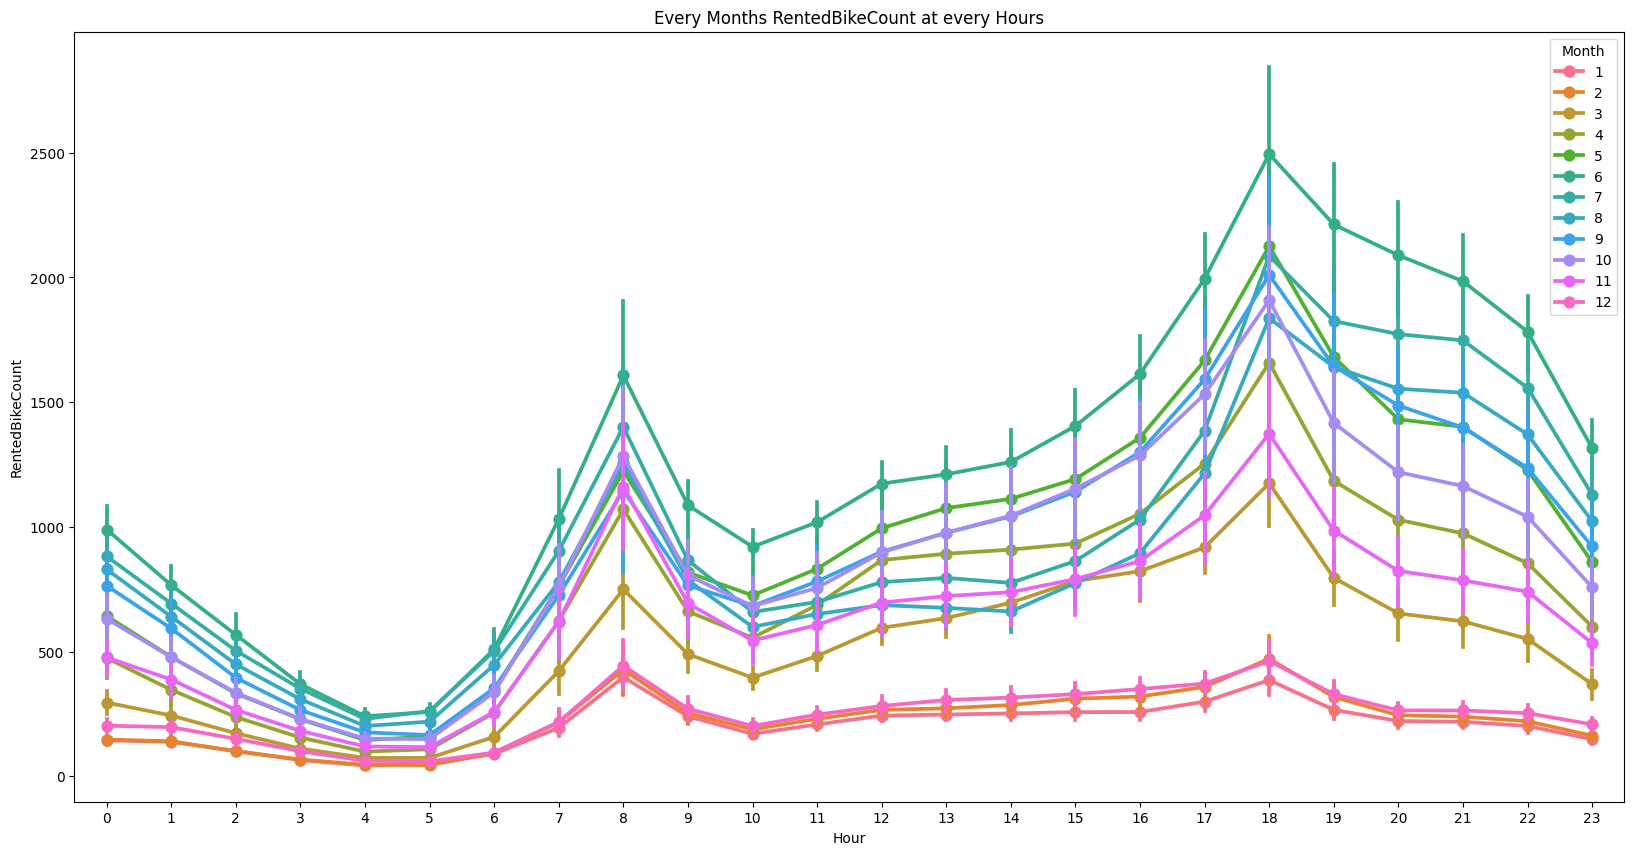

In [358]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.pointplot(data=dataset[['Hour', 'RentedBikeCount', 'Month']], x='Hour', y='RentedBikeCount', hue='Month', ax=ax)
ax.set(title="Every Months RentedBikeCount at every Hours")

## 視覺化欄位關係圖，以便觀察分析自行車在各個季節的使用量

[Text(0.5, 1.0, 'Every Seasons RentedBikeCount at every Hours')]

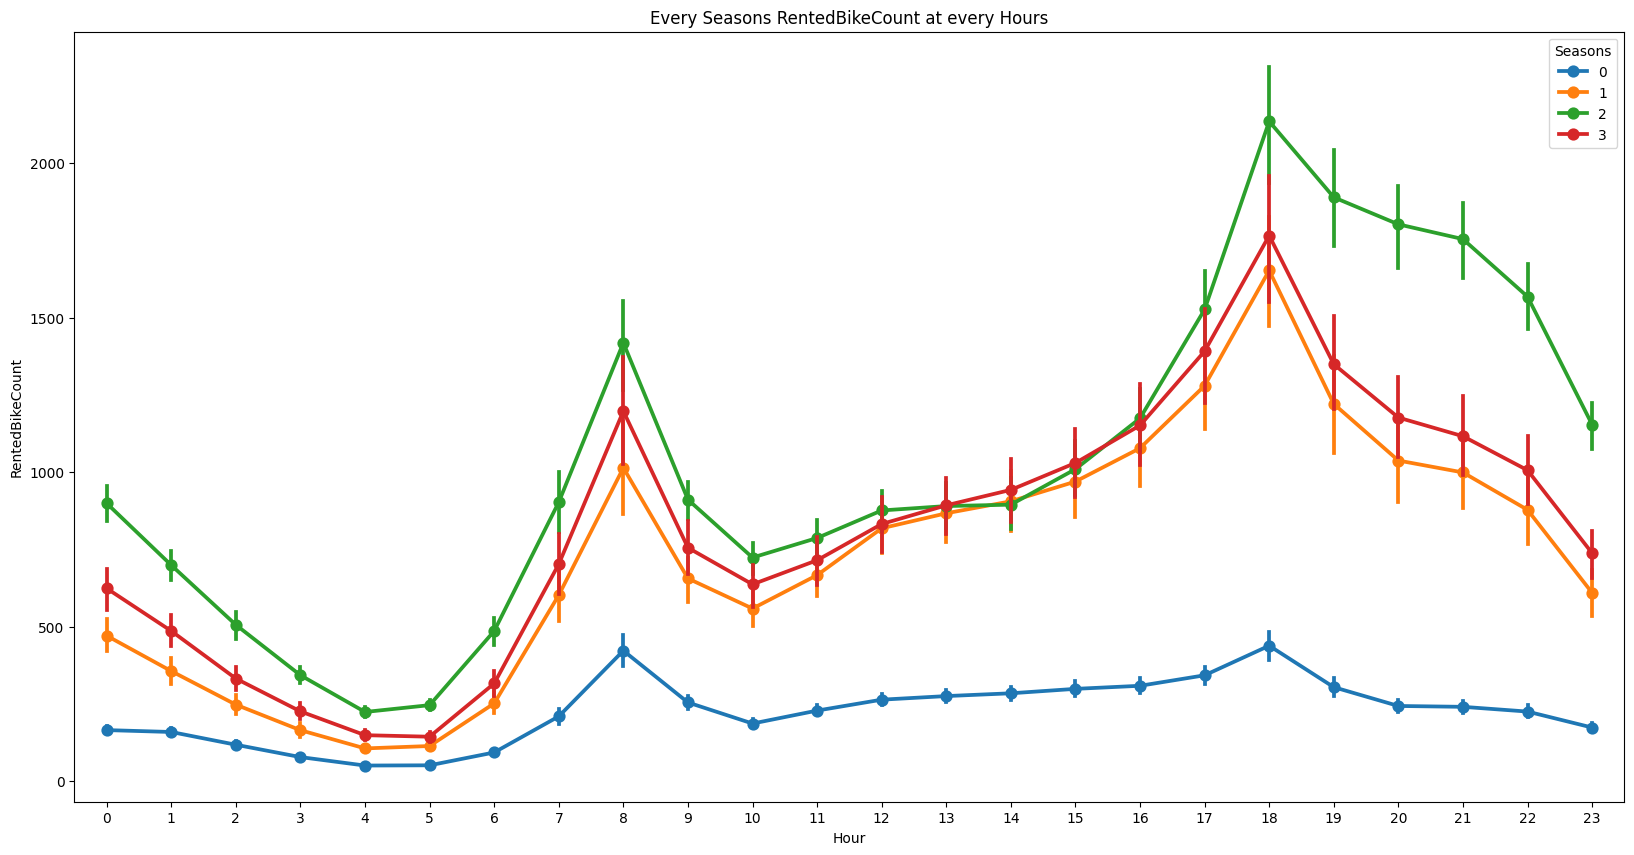

In [359]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.pointplot(data=dataset[['Hour', 'RentedBikeCount', 'Seasons']], x='Hour', y='RentedBikeCount', hue='Seasons', ax=ax)
ax.set(title="Every Seasons RentedBikeCount at every Hours")

## 檢查剩餘欄位的相關性
## 範圍是[-1,1]，絕對值越靠近0，表示不相關，絕對值越靠近1，表示相關性越強 小於 0 表示負相關；大於 0 表示正相關。

<Axes: >

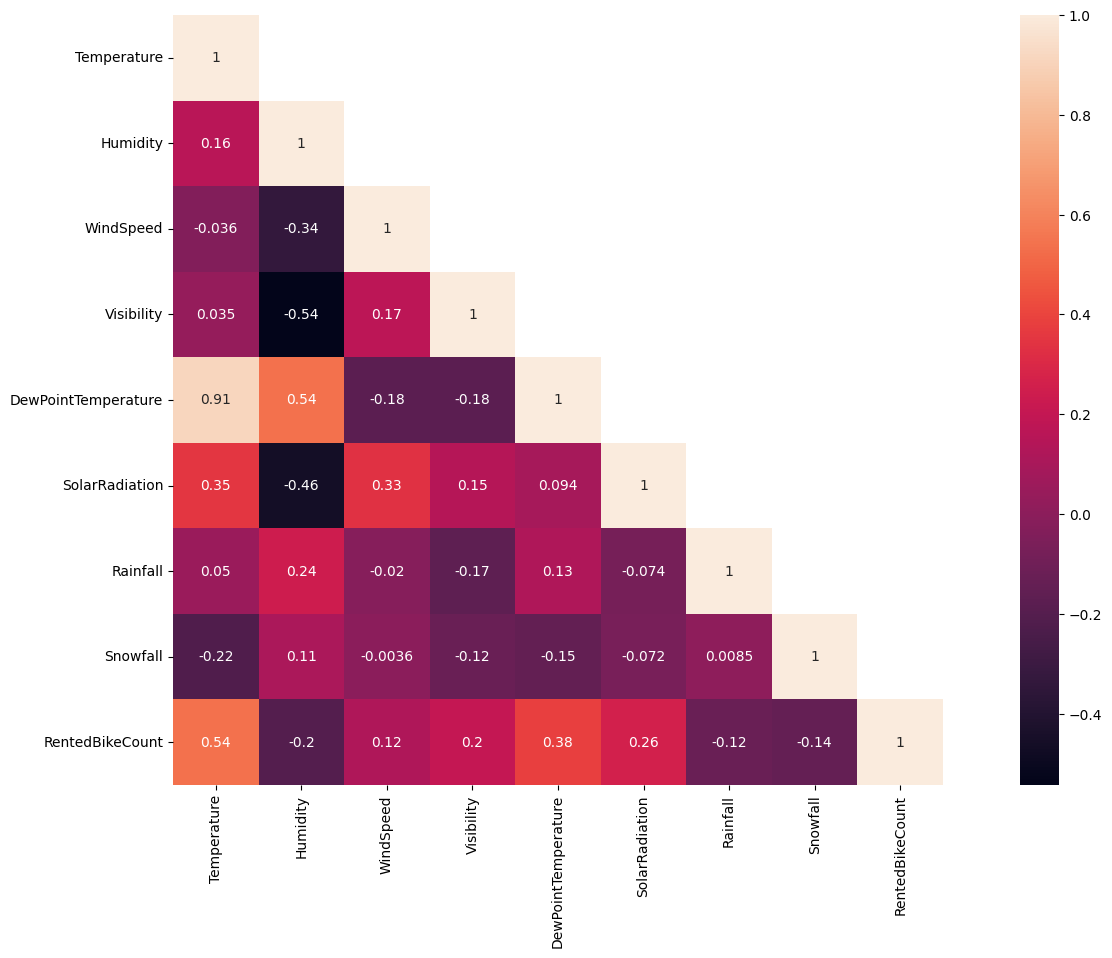

In [360]:
data_correlation = dataset[['Temperature', 'Humidity', 'WindSpeed', 'Visibility', 'DewPointTemperature', 'SolarRadiation', 'Rainfall', 'Snowfall', 'RentedBikeCount']].corr()
mask = np.array(data_correlation)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(20, 10))
sns.heatmap(data_correlation, mask=mask, vmax=1, square=True, annot=True)

## 去除掉幾乎沒甚麼關聯性的欄位

In [361]:
dataset = dataset.drop(['WindSpeed', 'DewPointTemperature', 'Snowfall'], axis=1)

In [362]:
dataset.dtypes

Month              category
RentedBikeCount       int64
Hour               category
Temperature         float64
Humidity              int64
Visibility            int64
SolarRadiation      float64
Rainfall            float64
Seasons            category
Holiday            category
FunctioningDay     category
dtype: object

In [363]:
# dataset = dataset.drop(['Humidity', 'Rainfall'], axis=1)

## 檢查異常值，異常值可能會導致更長的訓練時間及錯誤的結果

[Text(0.5, 1.0, 'Boxplot for Seasons')]

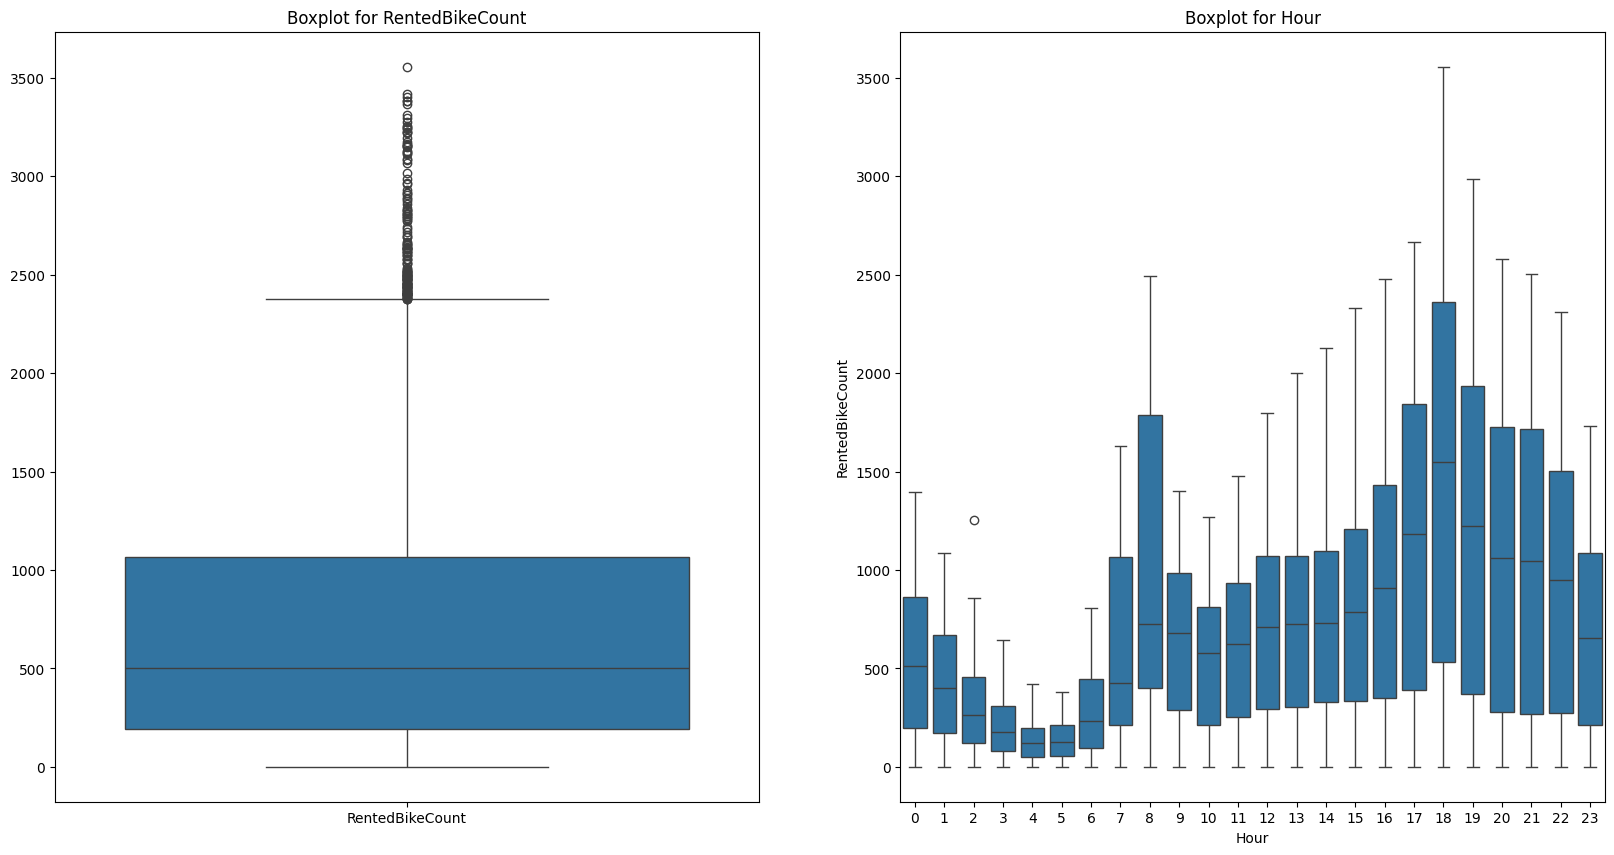

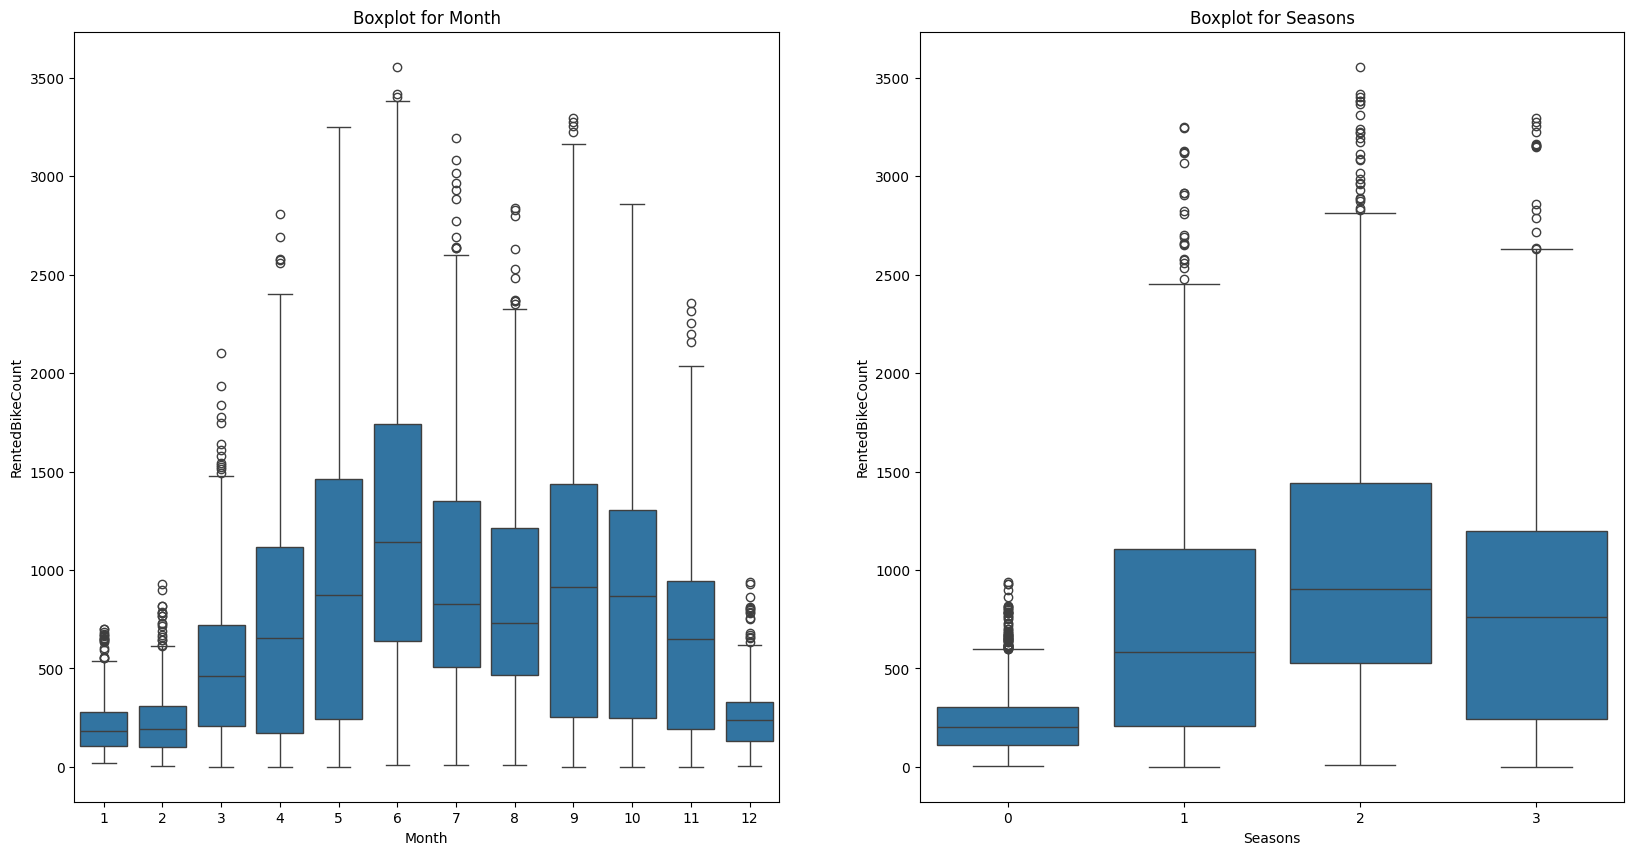

In [364]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
sns.boxplot(data=dataset[['RentedBikeCount']], ax=ax1)
ax1.set(title='Boxplot for RentedBikeCount')
sns.boxplot(x=dataset['Hour'], y=dataset['RentedBikeCount'], ax=ax2)
ax2.set(title='Boxplot for Hour')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
sns.boxplot(x=dataset['Month'], y=dataset['RentedBikeCount'], ax=ax1)
ax1.set(title='Boxplot for Month')
sns.boxplot(x=dataset['Seasons'], y=dataset['RentedBikeCount'], ax=ax2)
ax2.set(title='Boxplot for Seasons')

## 繪圖確認是否正態分布

C:\Users\chsta\AppData\Local\Temp\ipykernel_15116\1552518175.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['RentedBikeCount'], ax=ax1)


[Text(0.5, 1.0, 'Theoretical quantiles')]

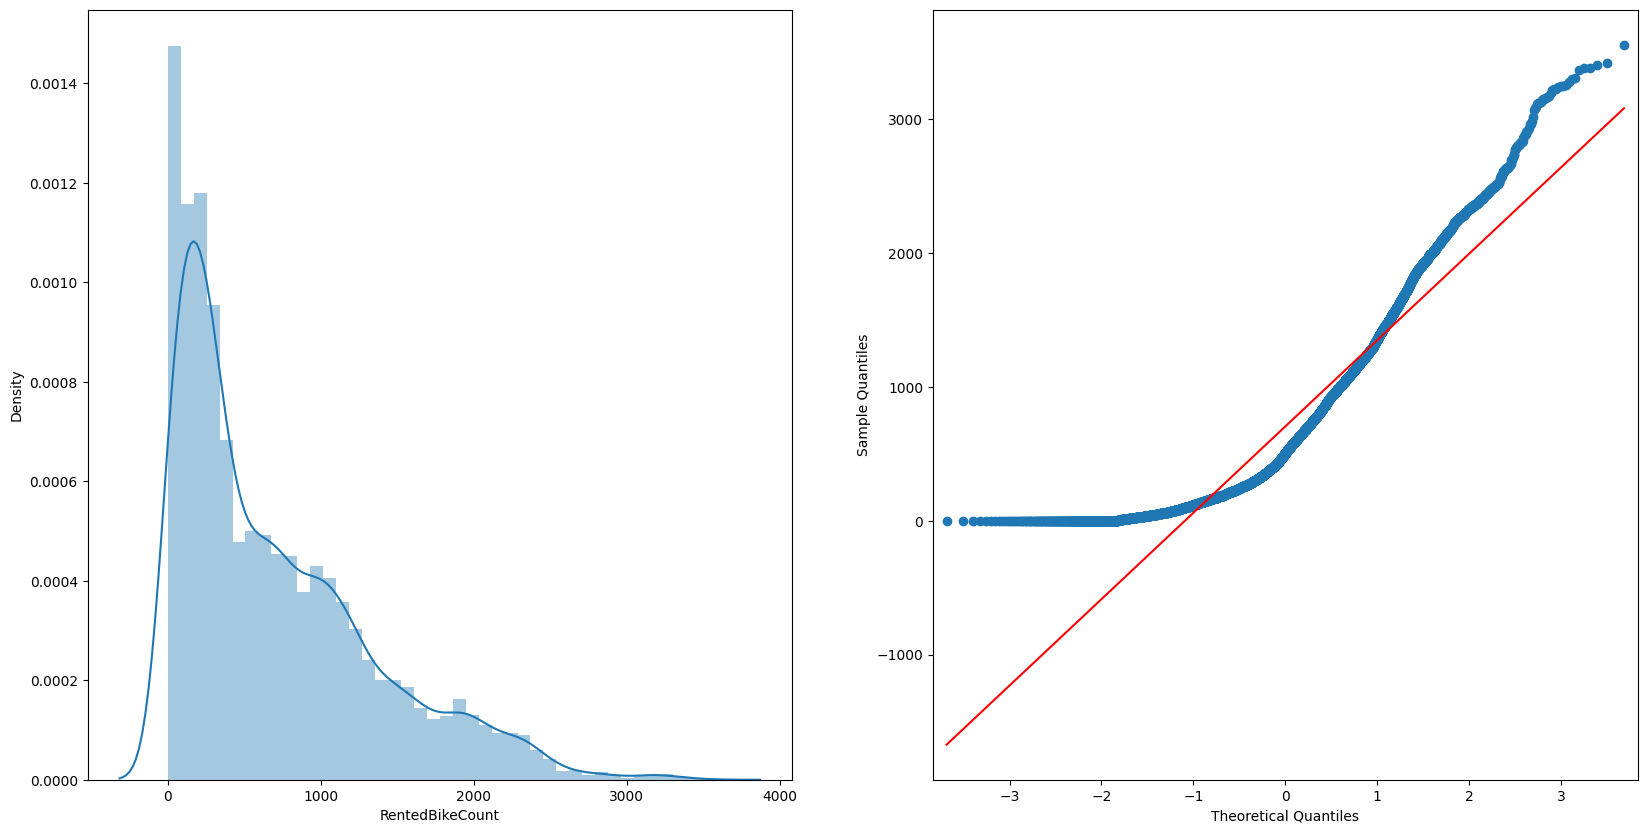

In [365]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
sns.distplot(dataset['RentedBikeCount'], ax=ax1)
ax.set(title='Distribution after log of RentedBikeCount')
qqplot(dataset['RentedBikeCount'], line='s', ax=ax2)
ax.set(title='Theoretical quantiles')

In [366]:
dataset.dtypes

Month              category
RentedBikeCount       int64
Hour               category
Temperature         float64
Humidity              int64
Visibility            int64
SolarRadiation      float64
Rainfall            float64
Seasons            category
Holiday            category
FunctioningDay     category
dtype: object

## 利用log將偏差範圍縮小固定

In [367]:
dataset['RentedBikeCount'] = dataset['RentedBikeCount'].transform(lambda x: math.log(x))

C:\Users\chsta\AppData\Local\Temp\ipykernel_15116\1552518175.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['RentedBikeCount'], ax=ax1)


[Text(0.5, 1.0, 'Theoretical quantiles')]

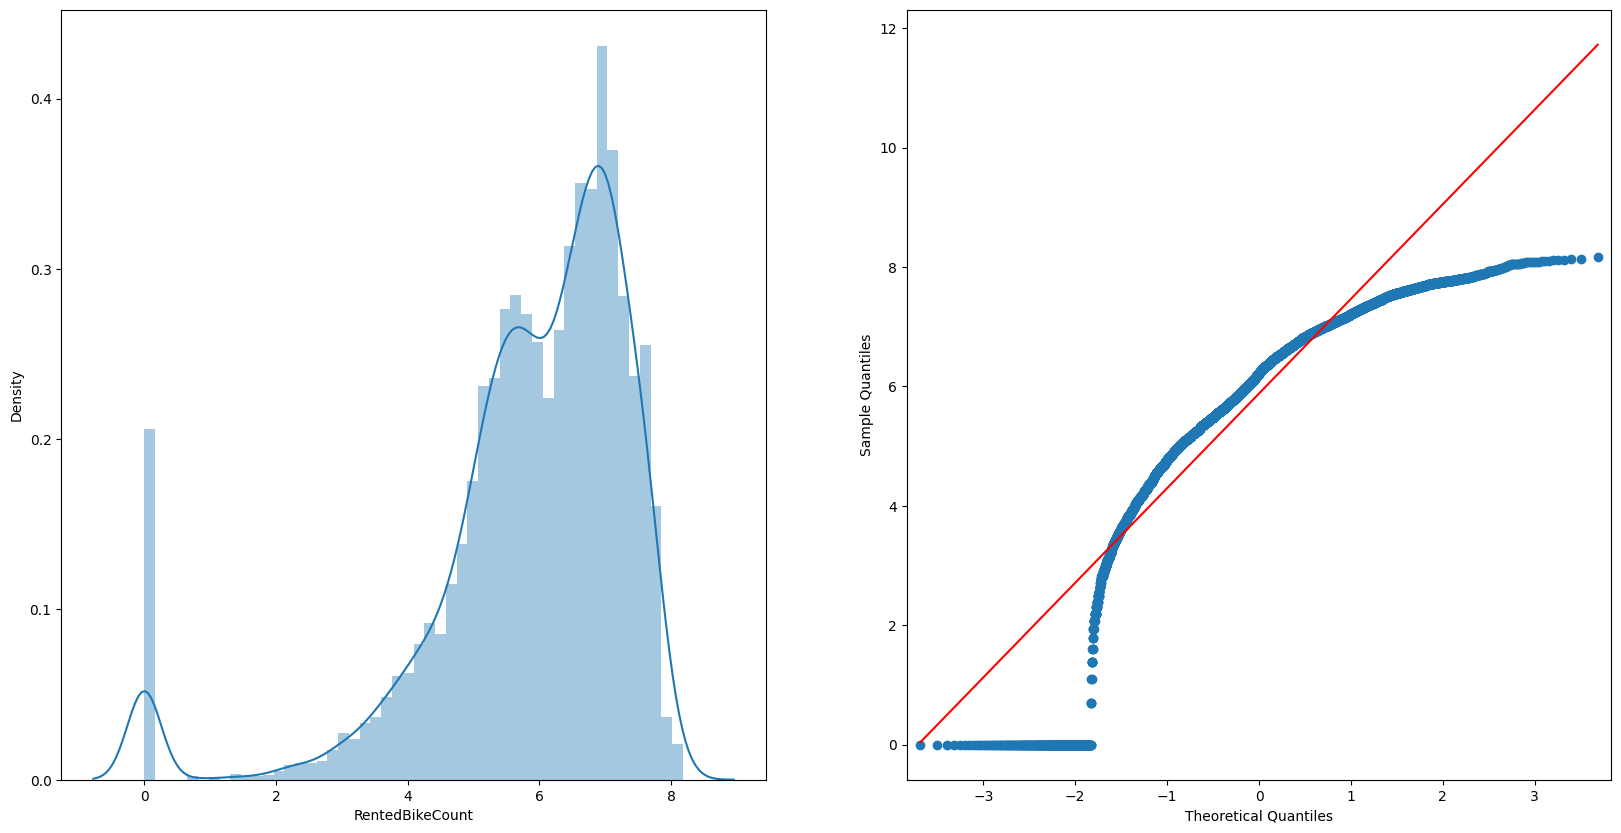

In [383]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
sns.distplot(dataset['RentedBikeCount'], ax=ax1)
ax.set(title='Distribution after log of RentedBikeCount')
qqplot(dataset['RentedBikeCount'], line='s', ax=ax2)
ax.set(title='Theoretical quantiles')

## 用One Hot Encoding 熱編碼來將作為分類屬性的欄位進行轉換，轉換成相互之間具有相同的權重

In [369]:
dataset.head()

,Month,RentedBikeCount,Hour,Temperature,Humidity,Visibility,SolarRadiation,Rainfall,Seasons,Holiday,FunctioningDay
0,12,5.537334,0,-5.2,37,2000,0.0,0.0,0,0,1
1,12,5.318120,1,-5.5,38,2000,0.0,0.0,0,0,1
2,12,5.153292,2,-6.0,39,2000,0.0,0.0,0,0,1
3,12,4.672829,3,-6.2,40,2000,0.0,0.0,0,0,1
4,12,4.356709,4,-6.0,36,2000,0.0,0.0,0,0,1


In [370]:
dataset_dummy = dataset

def dummify_dataset(df, colum):
    df = pd.concat([df, pd.get_dummies(df[colum], prefix=colum, drop_first=True)], axis=1)
    df = df.drop([colum], axis=1)
    return df

colums_to_dummify = ['Month', 'Hour', 'Seasons', 'Holiday', 'FunctioningDay']
for colum in colums_to_dummify:
    dataset_dummy = dummify_dataset(dataset_dummy, colum)

dataset_dummy.head()

,RentedBikeCount,Temperature,Humidity,Visibility,SolarRadiation,Rainfall,Month_2,Month_3,Month_4,Month_5,...,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Seasons_1,Seasons_2,Seasons_3,Holiday_1,FunctioningDay_1
0,5.537334,-5.2,37,2000,0.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,5.318120,-5.5,38,2000,0.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,5.153292,-6.0,39,2000,0.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,4.672829,-6.2,40,2000,0.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,4.356709,-6.0,36,2000,0.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## 切割 Train Data 和 Test Data

In [391]:
y = dataset_dummy['RentedBikeCount']
X = dataset_dummy.drop(['RentedBikeCount'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print('dataset shape:', dataset_dummy.shape)
print('Training data shape:', X_train.shape)
print('Testing data shape:', X_test.shape)

dataset shape: (8760, 45)
Training data shape: (5869, 44)
Testing data shape: (2891, 44)


## 建立models(包含多種算法)

In [392]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor

models = [LinearRegression(),
          Ridge(),
          HuberRegressor(),
          ElasticNetCV(),
          DecisionTreeRegressor(),
          ExtraTreesRegressor(),
          GradientBoostingRegressor(),
          RandomForestRegressor(),
          BaggingRegressor()]

def test_algorithms(model):
    kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)
    predicted = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print(predicted.mean())

for model in models:
    test_algorithms(model)

-0.3843184829230969
-0.3843332911663266


f:\DataMining\.conda\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
f:\DataMining\.conda\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
f:\DataMining\.conda\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_ite

-1.2784259916449274
-1.9019786923545823
-0.3709728003313664
-0.19617213329191868
-0.24399718920405142
-0.19717418449978705
-0.2193238931673632


## 依上述9個演算法比較後得出最好的成果的演算法來進行後續train test

In [393]:
from sklearn.metrics import mean_squared_log_error

# etr = RandomForestRegressor()
# etr.fit(X_train, y_train)
# y_pred = etr.predict(X_test)

etr = ElasticNetCV()
etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)

Residual Plot | Root Squared Mean Log Error: 0.3711208988268587


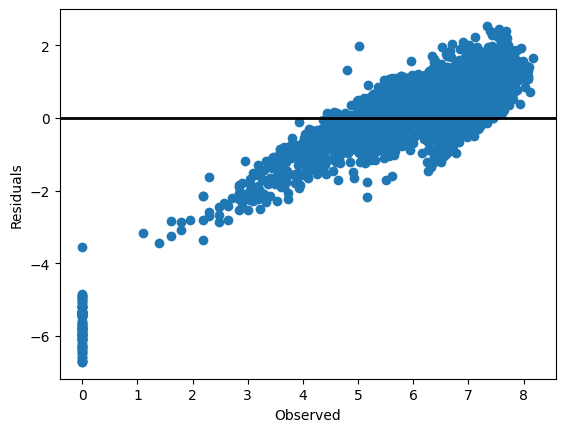

In [394]:
residuals = y_test - y_pred
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ans = np.sqrt(mean_squared_log_error(y_test, y_pred))
print('Residual Plot | Root Squared Mean Log Error:', ans)
# ax.title.set_text('Residual Plot | Root Squared Mean Log Error:')
plt.show()

## 改進模型(ex.利用PCA(降維)把對模型不必要的功能去掉，雖然這可能會導致信息丟失，但有助於減少維度)

Text(0, 0.5, 'Explained variance')

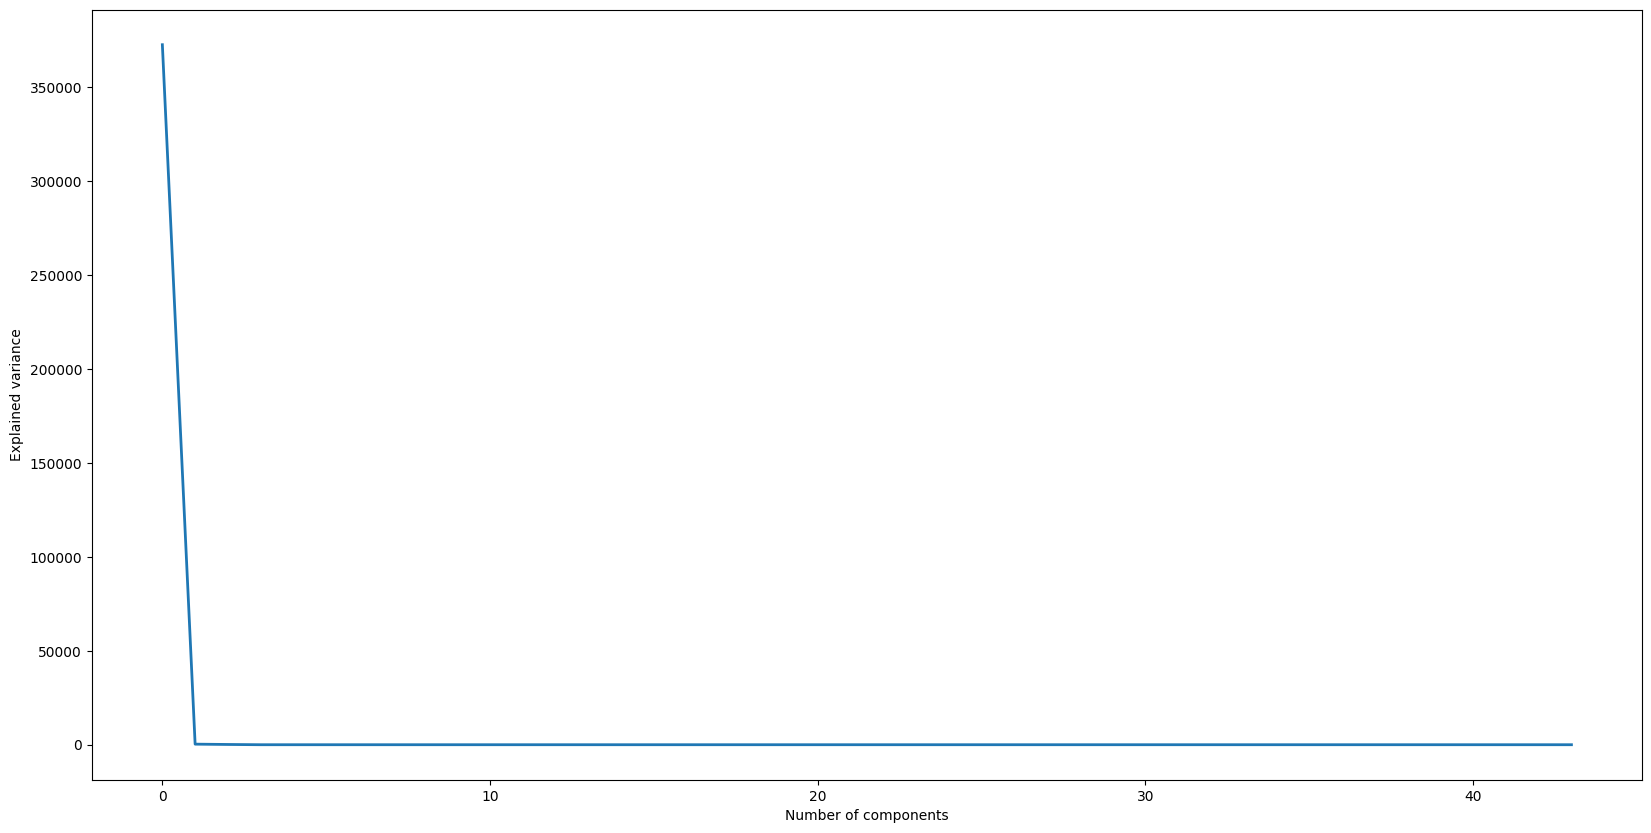

In [376]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.fit(X_train)

plt.figure(1, figsize=(20, 10))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [377]:
from sklearn.pipeline import Pipeline

etr = RandomForestRegressor()

pipline = Pipeline(steps=[('pca', pca), ('etr', etr)])

from sklearn.model_selection import GridSearchCV

print(pipline.get_params())

{'memory': None, 'steps': [('pca', PCA()), ('etr', RandomForestRegressor())], 'verbose': False, 'pca': PCA(), 'etr': RandomForestRegressor(), 'pca__copy': True, 'pca__iterated_power': 'auto', 'pca__n_components': None, 'pca__n_oversamples': 10, 'pca__power_iteration_normalizer': 'auto', 'pca__random_state': None, 'pca__svd_solver': 'auto', 'pca__tol': 0.0, 'pca__whiten': False, 'etr__bootstrap': True, 'etr__ccp_alpha': 0.0, 'etr__criterion': 'squared_error', 'etr__max_depth': None, 'etr__max_features': 1.0, 'etr__max_leaf_nodes': None, 'etr__max_samples': None, 'etr__min_impurity_decrease': 0.0, 'etr__min_samples_leaf': 1, 'etr__min_samples_split': 2, 'etr__min_weight_fraction_leaf': 0.0, 'etr__n_estimators': 100, 'etr__n_jobs': None, 'etr__oob_score': False, 'etr__random_state': None, 'etr__verbose': 0, 'etr__warm_start': False}


In [ ]:
hyperparameters = {'etr__n_estimators' : [10, 100, 500],
                   'etr__max_depth' : [None, 20, 50],
                   'pca__n_components' : [9, 19, 39]}

clf = GridSearchCV(pipline, hyperparameters, cv=10)

clf.fit(X_train, y_train)

print(clf.best_params_)

In [ ]:
y_pred = clf.predict(X_test)

residuals = y_test - y_pred
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text('Residual Plot | Root Squared Mean Log Error: ' + str(np.sqrt(mean_squared_log_error(y_test, y_pred))))
plt.show()

In [ ]:
# x = dataset.iloc[:, [0, 1]].values ## x為自變量(Month, Rented Bike Count)
# y = dataset.iloc[:, 2].values ## y為應變量(Hour)

# labelencoder_date = LabelEncoder() ## 預處理dataframe的Month
# x[:, 0] = labelencoder_date.fit_transform(x[:, 0])
# month = ColumnTransformer([('Month', OneHotEncoder(), [0])], remainder='passthrough')
# X = month.fit_transform(x)


# labelencoder_hour = LabelEncoder() ## 預處理dataframe的Hour
# y[:, 0] = labelencoder_hour.fit_transform(y[:, 0])
# hour = ColumnTransformer([('Hour', OneHotEncoder(), [0])], remainder='passthrough')
# Y = hour.fit_transform(y)

# labelencoder_seasons = LabelEncoder() ## 預處理dataframe的Seasons
# x[:, 2] = labelencoder_seasons.fit_transform(x[:, 2])
# season = ColumnTransformer('Seasons', OneHotEncoder(), [2], remainder='passthrough')
# Season = season.fit_transform(x.iloc[:, 2])

# labelencoder_holiday = LabelEncoder() ## 預處理dataframe的Holiday
# x[:, 3] = labelencoder_holiday.fit_transform(x[:, 3])
# # holiday = ColumnTransformer('Holiday', OneHotEncoder(), [3], remainder='passthrough')
# # Holiday = holiday.fit_transform(x.iloc[:, 3])

# labelencoder_functioning_day = LabelEncoder() ## 預處理dataframe的Functioning Day
# x[:, 4] = labelencoder_functioning_day.fit_transform(x[:, 4])
# # functioningDay = ColumnTransformer('FunctioningDay', OneHotEncoder(), [], remainder='passthrough')
# # FunctioningDay = functioningDay.fit_transform(x.iloc[:, 4])


##///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////##
# dataset_date = dataset.iloc[:, 0] ## 變更dataframe的Date
# dataset_year = []
# dataset_month = []
# dataset_day = []
# for str in dataset_date:
#     date_str = str.split('/')
#     dataset_day.append(int(date_str[0]))
#     dataset_month.append(int(date_str[1]))
#     dataset_year.append(int(date_str[2]))
    
# del dataset['Date']
# dataset.insert(0, 'Day', dataset_day)
# dataset.insert(0, 'Month', dataset_month)
# dataset.insert(0, 'Year', dataset_year)

# dataset_holiday = dataset.iloc[:, 14] ## 變更dataframe的Holiday
# for i in range(len(dataset_holiday)):
#     if dataset.iloc[i, 14] == 'No Holiday':
#         dataset.iloc[i, 14] = 0
#     elif dataset.iloc[i, 14] == 'Holiday':
#         dataset.iloc[i, 14] = 1
#     else:
#         print('Data Error(Holiday) row = ', i)

# dataset_functioning_day = dataset.iloc[:, 15] ## 變更dataframe的Functioning Day
# for i in range(len(dataset_functioning_day)):
#     if dataset.iloc[i, 15] == 'No':
#         dataset.iloc[i, 15] = 0
#     elif dataset.iloc[i, 15] == 'Yes':
#         dataset.iloc[i, 15] = 1
#     else:
#         print('Data Error(Functioning Day) row = ', i)


# print(len(dataset.axes[0])) ## 查看總行數
# print(len(dataset.axes[1])) ## 查看總列數


特徵縮放


In [ ]:
# ssc = StandardScaler()
# x_train = ssc.fit_transform(x_train)
# x_test = ssc.fit_transform(x_test)
# # x_test

繪製決策邊界Function

In [ ]:
# def plot_decision_regions(X, y, classifier, test_idex=None, resolution=0.02):
#     # markers = ('o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', '+', 'x') ## 設定標記

#     x1_min, x1_max = X[:, 0].min()-1, X[:, 0].max()+1
#     x2_min, x2_max = X[:, 1].min()-1, X[:, 1].max()+1

#     xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
#                          np.arange(x2_min, x2_max, resolution))
    
#     z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
#     z = z.reshape(xx1.shape)
#     plt.contourf(xx1, xx2, z, alpha=0.8)
#     plt.xlim(xx1.min(), xx1.max())
#     plt.ylim(xx2.min(), xx2.max())

#     print('y:', y)
#     for idx, cl in enumerate(np.unique(y)):
#         plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, label=cl)
#     if test_idex:
#         X_test, y_test = X[test_idex, :], y[test_idex]
#         plt.scatter(X_test[:, 0], X_test[:, 1], alpha=1.0, linewidths=1, marker='', s=55, label='test set')

實行Classification


In [ ]:
# decisionTreeModel = DecisionTreeClassifier(criterion= 'gini', random_state=0)
# decisionTreeModel.fit(x_train, y_train)

# pred = decisionTreeModel.predict(x_test)
# print(pred)
# print(y_test)

In [ ]:
# plot_decision_regions(x_train, y_train, decisionTreeModel)
# print('train set accurancy:', decisionTreeModel.score(x_train, y_train))

# # cm = confusion_matrix(y_test, pred)

# # plt.figure(figsize=(15,8))
# # sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
# # plt.xlabel('Pred',fontsize=20)
# # plt.ylabel('True',fontsize=20)
# # plt.show()

In [ ]:
# plot_decision_regions(x_test, y_test, decisionTreeModel)
# print('test set accurancy:', decisionTreeModel.score(x_test, y_test))

將結果繪圖

In [ ]:
# x_set, y_set = x_train, y_train
# x1, x2 = np.meshgrid(np.arange(start = x_set[:, 0].min()-1, stop = x_set[:, 0].max()+1, step = 0.01),
#                      np.arange(start = x_set[:, 1].min()-1, stop = x_set[:, 1].max()+1, step = 0.01))
# plt.contourf(x1, x2, classifier.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape),
#              alpha=0.75, cmap=ListedColormap(('red', 'green')))
# plt.xlim(x1.min(), x1.max())
# plt.ylim(x2.min(), x2.max())

# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1], c=ListedColormap(('orange', 'blue'))(i), label=j)
# plt.title('classifier (Train set)')
# plt.xlabel('Month')
# plt.ylabel('Rented Bike Count')
# plt.legend()
# plt.show()


In [ ]:
# x_set, y_set = x_test, y_test
# x1, x2 = np.meshgrid(np.arange(start = x_set[:, 0].min()-1, stop = x_set[:, 0].max()+1, step = 0.01),
#                      np.arange(start = x_set[:, 1].min()-1, stop = x_set[:, 1].max()+1, step = 0.01))
# plt.contourf(x1, x2, classifier.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape),
#              alpha=0.75, cmap=ListedColormap(('red', 'green')))
# plt.xlim(x1.min(), x1.max())
# plt.ylim(x2.min(), x2.max())

# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1], c=ListedColormap(('orange', 'blue'))(i), label=j)
# plt.title('classifier (Test set)')
# plt.xlabel('Month')
# plt.ylabel('Rented Bike Count')
# plt.legend()
# plt.show()